# Analyzing the Role of Socioeconomic Factors in Transportation & Health Outcomes:<br>
### _An NLP Approach_

## Introduction

### Background

* The social determinants of health (SDOH) are non-medical factors that can influence public health (WHO). <br>
* Factors based on <a href="https://www.annualreviews.org/content/journals/10.1146/annurev-publhealth-031210-101218">The Social Determinants of Health: Coming of Age</a> are: <br>
    * <u>Neighbourhood Conditions:</u> social + physical environments; individual health
    * <u>Working Conditions:</u> employment-related factors (the physical aspects of working as well as the work environment; psychosocial aspects; opportunities & resources)
    * <u>Education:</u> educational opportunities and the social & psychological factors associated
    * <u>Income & Wealth:</u> socioeconomic status, the environment one grows up with, and the resources they have access to
    * <u>Race & Racism:</u> racial disparities in health & healthcare
    * <u>Stress:</u> psychological stressors (their causes & effects)
* I have also identified common themes between these classifications, and made note of them, as follows: 

    * <u>Environment</u>: the physical landscape of the environment, services available, individual health, the physical aspects of work (eg muscle strain, back pain), the work environment (eg collaborative, desk space, etc), area demographics, economic hardship, racial discrimination, relative social status
    * <u>Social/Psychological</u>: social relationships, individual health, stress, subjective social status, self-perception
    * <u>Opportunities & Resources</u>: literacy, employment opportunities, literacy, income/wealth, education, social safety nets, Medicare, etc.
    * <u>Biological Effects</u>: release of cortisol & cytokines, ageing, disease
* Socioeconomic factors (SEFs) such as income, education, and employment play a crucial role in shaping transportation accessibility and health outcomes. 
* From the list above, we are interested in investigating **accessibility and transportation** which falls under the category of **Neighbourhood Conditions** because they are related to the social and physical environment people live in, which affects people's mobility and daily life activities
* Accessibility to transportation is also deeply tied with the other themes since socioeconomic status can affect vehicle ownership and access. Lack of transportation can cause psychological stress and increase daily burdens. Having limited transportation also limits access to healthcare, a solid education, and a stable job. All these factors affect people's overall well-being.

### Research Question

**Research Question**: Are research studies on public health more likely to mention transportation accessibility compared to other topics, and how is this relationship framed?

**Purpose**: to examine how accessibility to transportation is discussed in relation to public health by using NLP techniques to identify key themes, sentiment, and the frequency of associations in textual data from research studies

**Objectives:** <br>
1) To use NLP techniques to extract and categorize recurring themes in research studies discussing transportation accessibility and public health
2) To compare how often transportation is mentioned relative to other public health concerns (ie employment, education, income & wealth, race, and stress)
3) To analyze whether accessibility is discussed as a positive,  negative, or neutral factor in health outcomes
4) To identify patterns in how transportation is framed in relation to health (eg beneficial and improving healthcare access, or as a barrier and worsening disparities in health)

**Hypothesis**: Public health research studies are more likely to mention transportation accessibility compared to other social determinants of health, and they predominantly frame it as a positive factor for health outcomes.

In [53]:
# import packages
import spacy, re, nltk
import pandas as pd
import xml.etree.ElementTree as ET
import scipy

from collections import Counter

# NLP Packages
import gensim
import string
import re
import gensim.corpora as corpora
from scipy.linalg import triu
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



In [54]:
nlp = spacy.load("en_core_web_sm")

## Data Collection

### Data Acquisition Methods

* Collected 50 research articles about public health from the Internet and stored them in Mendeley Reference Manager
* Exported the references as a .xml file
* Stored the contents of the research articles each in a .txt file in an articles folder

## Data Processing and Preprocessing

### Text Data Preprocessing

In [55]:
# divide text into sections by label
def split_by_label(text, labels):
    pattern = '|'.join(re.escape(label) for label in labels)
    sections = re.split(pattern, text)
    return sections

In [56]:
# get the section labels for Article 1
labels = []
with open ('./articles/article1.txt', 'r') as file:
    for line in file:
        if line.strip() and not line.startswith((" ", "\t")):  # line is not indented
            labels.append(line.strip())
labels

['Abstract',
 'Health-care–related transportation insecurity is common in the',
 'United States. Patients with cancer are especially vulnerable',
 'because cancer care is episodic in nature, occurs over a',
 'prolonged period, is marked by frequent clinical encounters,',
 'requires intense treatments, and results in substantial',
 'financial hardship. As a result of transportation insecurity,',
 'patients with cancer may forego, miss, delay, alter, and/or',
 'prematurely terminate necessary care. Limited data suggest that',
 'these alterations in care have the potential to increase the',
 'rates of cancer recurrence and mortality and exacerbate',
 'disparities in cancer incidence, severity, and outcomes.',
 'Transportation insecurity also negatively impacts at the',
 'informal caregiver, provider, health system, and societal',
 'levels. Recognizing that transportation is a critical',
 'determinant of outcomes for patients with cancer, there are',
 'ongoing efforts to develop evidence-b

In [57]:
# placing the words from the article in a list / string
no_blanks = []
with open ('./articles/article1.txt', 'r') as f:
    lines = f.readlines()
    stripped_words = [[word.strip() for word in line.split() if len(word) > 0] for line in lines]
    for lst in stripped_words:
        if len(lst) > 0:
            no_blanks.append(lst)

In [58]:
# Stop Words
stop_words = set(stopwords.words("English"))

In [59]:
# Clean text - remove stopwords, punctuation, and special characters
def preprocess(word):
    word = re.sub(r"[^\w\s]", " ", word) # remove punctuation and special characters (anything that is not word or whitespace)
    word = re.sub(r"\d+", "", word) # remove numbers
    word = word.lower()
    if word not in stop_words:
        return word
    else:
        return ''

In [60]:
# cleaned text as a string
article_text = ' '.join([preprocess(word) for lst in no_blanks for word in lst])
article_text = ' '.join(article_text.split())
article_text



'abstract health care related transportation insecurity common united states patients cancer especially vulnerable cancer care episodic nature occurs prolonged period marked frequent clinical encounters requires intense treatments results substantial financial hardship result transportation insecurity patients cancer may forego miss delay alter and or prematurely terminate necessary care limited data suggest alterations care potential increase rates cancer recurrence mortality exacerbate disparities cancer incidence severity outcomes transportation insecurity also negatively impacts informal caregiver provider health system societal levels recognizing transportation critical determinant outcomes patients cancer ongoing efforts develop evidence based protocols identify at risk patients address transportation insecurity federal policy health system not for profit industry levels national cancer policy forum national academies science engineering medicine sponsored series webinars address

### Named Entity Recognition

Let's investigate how common words fall in the categories of the social determinants of health and its related topics. The topics we will investigate in our text are:<br>
* **Social Determinants of Health:** the non-medical factors that influence a person's health (WHO)<br>
* **Health:** a person's physical, mental, and emotional well-being in a general sense, not necessarily related to the social determinants of health<br>
* **Privilege:** this may be mentioned a lot if SDOH is found to favor some people over others<br>
* **Socioeconomic status:** a measurement of where people stand socially or economically; this may be crucial to the social determinants of health<br>
* **Transportation:** we are interested in whether an association exists between transportation and the social determinants of health. By looking at positive/negative sentiment of the word along with topics related to privilege and socioeconomic status, we can get a better understanding of how inequalities in accessibility to transportation affect public health.<br>

In [61]:
sdoh_words = [
    "access", "poverty", "education", "employment", "housing", "nutrition", "environment", 
    "equity", "income", "stress", "safety", "transport", "literacy", "insurance", 
    "community", "resources", "disparity", "inequality", "lifestyle", "socioeconomic", 
    "healthcare", "discrimination", "segregation", "neighborhood", "accessibility", 
    "prevention", "opportunity", "advocacy", "wellness", "infrastructure", "support", 
    "inclusion", "participation", "mobility", "stability", "vulnerability", "diversity", 
    "integration", "outreach", "screening", "services", "policy", "networks", "empowerment", 
    "collaboration", "demographics", "risk", "culture", "barriers", "awareness"
]
sdoh_lemma = [word.lemma_ for word in nlp(' '.join(sdoh_words))]

In [62]:
transportation_words = [
    'transportation', 'mobility', 'infrastructure', 'commute', 'traffic', 'roadway',
    'vehicle', 'automobile', 'rail', 'bus', 'subway', 'cycle', 'carpool', 'pedestrian',
    'congestion', 'accessibility', 'logistics', 'freight', 'aviation', 'ports', 'shipping',
    'train', 'route', 'sustainability', 'emissions', 'efficiency', 'network', 'policy',
    'green', 'fuels', 'electric', 'self-driving', 'urban', 'system', 'equity', 'safety',
    'cyclist', 'carsharing', 'ridesharing', 'demand', 'cost', 'vehicle-sharing', 'transport',
    'motion', 'access', 'distance', 'trip', 'congestion', 'platform', 'traffic-jam', 'driver',
    'passenger', 'hub'
]


In [63]:
def find_mentions(text, keywords):
    doc =  nlp(text)
    mentions = [token.text for token in doc if token.lower_ in keywords]
    entities = [ent.text for ent in doc.ents if ent.label_ in ['GPE', 'ORG', 'PERSON']]
    return mentions, entities
    

In [64]:
Counter(find_mentions(article_text, transportation_words)[0])

Counter({'transportation': 234,
         'cost': 39,
         'system': 30,
         'policy': 30,
         'safety': 10,
         'access': 9,
         'infrastructure': 8,
         'distance': 7,
         'demand': 3,
         'bus': 2,
         'urban': 2,
         'equity': 1,
         'vehicle': 1,
         'transport': 1,
         'trip': 1,
         'logistics': 1,
         'passenger': 1,
         'mobility': 1,
         'ridesharing': 1,
         'efficiency': 1})

In [65]:
Counter(find_mentions(article_text, sdoh_words)[1])

Counter({'medicaid': 16,
         'medicare': 12,
         'nemt': 5,
         'mtm': 5,
         'united states': 2,
         'emphysema lung': 1,
         'social determinants health disparities': 1,
         'continuum examine multilevel': 1,
         'continuum screening': 1,
         'american academy': 1,
         'illinois health s program': 1,
         'partnership university illinois health kaizen': 1})

### Thematic Analysis

#### LDA: Latent Dirichlet Allocation

In [66]:
no_blanks2 = []
with open ('./articles/article2.txt', 'r') as f:
    lines = f.readlines()
    stripped_words = [[word.strip() for word in line.split() if len(word) > 0] for line in lines]
    for lst in stripped_words:
        if len(lst) > 0:
            no_blanks2.append(lst)

In [67]:
# with just 2 articles
article_text2 = ' '.join([preprocess(word) for lst in no_blanks for word in lst])
article_text2 = ' '.join(article_text2.split())

In [68]:
Counter(find_mentions(article_text2, transportation_words)[0])

Counter({'transportation': 234,
         'cost': 39,
         'system': 30,
         'policy': 30,
         'safety': 10,
         'access': 9,
         'infrastructure': 8,
         'distance': 7,
         'demand': 3,
         'bus': 2,
         'urban': 2,
         'equity': 1,
         'vehicle': 1,
         'transport': 1,
         'trip': 1,
         'logistics': 1,
         'passenger': 1,
         'mobility': 1,
         'ridesharing': 1,
         'efficiency': 1})

In [69]:
Counter(find_mentions(article_text2, sdoh_words)[0])

Counter({'screening': 38,
         'policy': 30,
         'services': 15,
         'risk': 14,
         'barriers': 13,
         'safety': 10,
         'insurance': 10,
         'access': 9,
         'opportunity': 9,
         'housing': 8,
         'infrastructure': 8,
         'stress': 8,
         'participation': 8,
         'resources': 7,
         'income': 6,
         'inclusion': 5,
         'integration': 5,
         'employment': 4,
         'community': 4,
         'prevention': 2,
         'support': 2,
         'nutrition': 2,
         'equity': 1,
         'environment': 1,
         'neighborhood': 1,
         'transport': 1,
         'vulnerability': 1,
         'mobility': 1})

In [70]:
docs = [article_text, article_text2]


In [71]:
def preprocess_text(text):
    text = text.lower() 
    text = re.sub(r'\d+', '', text)  
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    tokens = simple_preprocess(text)  # this function includes tokenize text!
    tokens = [word for word in tokens if word not in stop_words] 
    return tokens

In [72]:
little_processed_docs = [preprocess_text(doc) for doc in docs]

In [73]:
little_dictionary = corpora.Dictionary(little_processed_docs)

In [74]:
corpus = [little_dictionary.doc2bow(doc) for doc in little_processed_docs]

In [75]:
little_lda_model = LdaModel(
    corpus=corpus,
    id2word=little_dictionary,
    num_topics=5,
    random_state=42,
    passes=10,
    per_word_topics=True
)


In [76]:
topics = little_lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.004*"transportation" + 0.003*"cancer" + 0.003*"insecurity" + 0.003*"health" + 0.003*"patients"')
(1, '0.003*"transportation" + 0.003*"cancer" + 0.003*"insecurity" + 0.002*"patients" + 0.002*"care"')
(2, '0.004*"transportation" + 0.003*"cancer" + 0.002*"patients" + 0.002*"insecurity" + 0.002*"health"')
(3, '0.007*"transportation" + 0.006*"cancer" + 0.005*"patients" + 0.004*"insecurity" + 0.004*"health"')
(4, '0.044*"transportation" + 0.037*"cancer" + 0.026*"insecurity" + 0.024*"patients" + 0.021*"health"')


In [77]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

little_lda_display = gensimvis.prepare(little_lda_model, corpus, little_dictionary)
pyLDAvis.display(little_lda_display)

In [78]:
import os
all_docs = []

# extract the text for all the articles
for article in os.listdir('./articles/'):
    text = []
    with open (f'./articles/{article}', 'r') as f:
        lines = f.readlines()
        stripped_words = [[word.strip() for word in line.split() if len(word) > 0] for line in lines]
        for lst in stripped_words:
            if len(lst) > 0:
                text.append(lst)
        
    article_text_str = ' '.join([preprocess(word) for lst in stripped_words for word in lst])
    article_text_str = ' '.join(article_text_str.split())
    all_docs.append(article_text_str)

In [79]:
all_docs

['abstract although cancer mortality rates declined united states recent decades populations experienced little benefit advances cancer prevention early detection treatment survivorship care fact cancer disparities populations low high socioeconomic status widened period many potentially preventable cancer deaths continue occur disadvantaged populations bear disproportionate burden reducing burden cancer eliminating cancer related disparities require focused coordinated action across multiple sectors partnership communities article part american cancer society s cancer control blueprint series introduces framework understanding addressing social determinants advance cancer health equity presents actionable recommendations practice research policy article aims accelerate progress toward eliminating disparities cancer achieving health equity introduction field cancer control crossroads despite progress cancer united states progress equitably benefitted population groups overall cancer de

In [80]:
processed_docs = [preprocess_text(doc) for doc in all_docs]

In [81]:
dictionary = corpora.Dictionary(processed_docs)

In [82]:
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [83]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=15,
    random_state=42,
    passes=10,
    per_word_topics=True
)

In [84]:
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.002*"health" + 0.001*"social" + 0.001*"transportation" + 0.001*"cancer" + 0.001*"care"')
(1, '0.001*"health" + 0.001*"transportation" + 0.000*"social" + 0.000*"care" + 0.000*"cancer"')
(2, '0.022*"health" + 0.022*"diabetes" + 0.015*"social" + 0.015*"sdoh" + 0.013*"care"')
(3, '0.006*"health" + 0.005*"cancer" + 0.004*"social" + 0.003*"patients" + 0.002*"transportation"')
(4, '0.002*"health" + 0.001*"transportation" + 0.001*"social" + 0.001*"cancer" + 0.001*"patients"')
(5, '0.002*"health" + 0.002*"social" + 0.001*"traffic" + 0.001*"transportation" + 0.001*"diabetes"')
(6, '0.002*"health" + 0.001*"social" + 0.001*"transportation" + 0.001*"care" + 0.001*"cancer"')
(7, '0.002*"health" + 0.001*"transportation" + 0.001*"social" + 0.001*"care" + 0.001*"cancer"')
(8, '0.033*"health" + 0.027*"social" + 0.026*"cancer" + 0.012*"care" + 0.011*"determinants"')
(9, '0.025*"traffic" + 0.014*"health" + 0.013*"social" + 0.013*"exposure" + 0.010*"et"')
(10, '0.001*"health" + 0.001*"social" + 0.00

In [85]:
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [86]:
from gensim.models import CoherenceModel

coherence_model_score = CoherenceModel(model = lda_model, texts = processed_docs, dictionary = dictionary, coherence = 'u_mass')
coherence_model_score.get_coherence()

-0.31894436747008054

In [87]:
print(f'Log Perplexity Score: {lda_model.log_perplexity(corpus)}')
# coherence: -0.391
# perplexity: -7.467

Log Perplexity Score: -7.379848137441972


**Coherence Score**: -0.391 < 0 --> relatively low; room for improvement
* May indicate the topics are not very coherent because the topics are not well-defined or are overlapping, don't capture meaningful semantic relationships, or there may be too many or too few topics for the dataset<br>
**Log Perplexity Score**: -7.467 --> perplexity = e^(-7.467) = 0.00057
* Low perplexity scores are generally good, but extremely low log perplexity scores may indicate overfitting if the model is too complex or the dataset is too small

#### Keyword Extraction

In [99]:
# imports
import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [112]:
# TF-IDF
# initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1_000)
tfidf_matrix = vectorizer.fit_transform(all_docs)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,ability,able,aboriginal,access,accessibility,accessible,account,accountable,achieve,achieving,...,work,workers,working,worse,would,yarning,year,years,yet,you
0,0.011239,0.008288,0.0,0.079985,0.000000,0.000000,0.009229,0.009229,0.018458,0.018458,...,0.020641,0.004144,0.002826,0.000000,0.000000,0.0,0.003098,0.000000,0.018587,0.0
1,0.003791,0.000000,0.0,0.039160,0.004669,0.002335,0.002335,0.009338,0.007004,0.014007,...,0.015664,0.008386,0.005719,0.012005,0.004289,0.0,0.003135,0.006884,0.001567,0.0
2,0.000000,0.003515,0.0,0.124736,0.000000,0.000000,0.000000,0.000000,0.003914,0.000000,...,0.015318,0.017574,0.019175,0.000000,0.002397,0.0,0.007882,0.023082,0.007882,0.0
3,0.027574,0.000000,0.0,0.037982,0.000000,0.042455,0.000000,0.016982,0.025473,0.000000,...,0.009495,0.000000,0.005200,0.000000,0.010400,0.0,0.005700,0.025038,0.005700,0.0
4,0.000000,0.000000,0.0,0.035615,0.042464,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017808,0.000000,0.003251,0.000000,0.003251,0.0,0.000000,0.000000,0.010691,0.0


In [130]:
top_n = 10
top_words = []
for i, text in enumerate(all_docs):
    top_words.append([])
    top_n_words = tfidf_matrix[i].toarray().argsort()[0][-10:] # get indices of top 10 words
    top_words[i] = ([vectorizer.get_feature_names_out()[i] for i in top_n_words]) # get the words from the indices

In [131]:
for i in range(len(top_words)):
    print(f'Article {i + 1}: {top_words[i]}')

Article 1: ['focused', 'disparities', 'address', 'determinants', 'patients', 'care', 'disadvantaged', 'social', 'health', 'cancer']
Article 2: ['hbac', 'prevalence', 'adults', 'food', 'care', 'social', 'sdoh', 'tdm', 'health', 'diabetes']
Article 3: ['family', 'services', 'access', 'group', 'mongolia', 'district', 'strategy', 'social', 'red', 'health']
Article 4: ['usa', 'physicians', 'cancer', 'social', 'health', 'ocm', 'programmes', 'oncologists', 'sdoh', 'patients']
Article 5: ['arterials', 'physical', 'streets', 'transportation', 'land', 'roads', 'health', 'social', 'arterial', 'traffic']
Article 6: ['bus', 'that', 'know', 've', 'indigenous', 'it', 'people', 'participants', 'transport', 'aboriginal']
Article 7: ['health', 'oncology', 'interventions', 'patients', 'insecurity', 'risk', 'trial', 'oncologists', 'cancer', 'sdoh']
Article 8: ['need', 'among', 'screening', 'treatment', 'care', 'health', 'patients', 'insecurity', 'transportation', 'cancer']
Article 9: ['handydart', 'aging'

In [132]:
# Compute average TF-IDF score for each word
avg_tfidf_scores = tfidf_df.mean().sort_values(ascending=False)

# Display the top N words with the highest TF-IDF scores
top_n = 20  # Change this to see more/less words
print(avg_tfidf_scores.head(top_n))


health            0.239573
cancer            0.152517
social            0.146675
sdoh              0.123178
transportation    0.122097
patients          0.114945
traffic           0.104142
care              0.098683
diabetes          0.071873
insecurity        0.062009
outcomes          0.056209
al                0.052401
et                0.052401
aboriginal        0.052260
community         0.047780
adults            0.047760
access            0.047292
oncologists       0.046338
older             0.045708
exposure          0.042143
dtype: float64


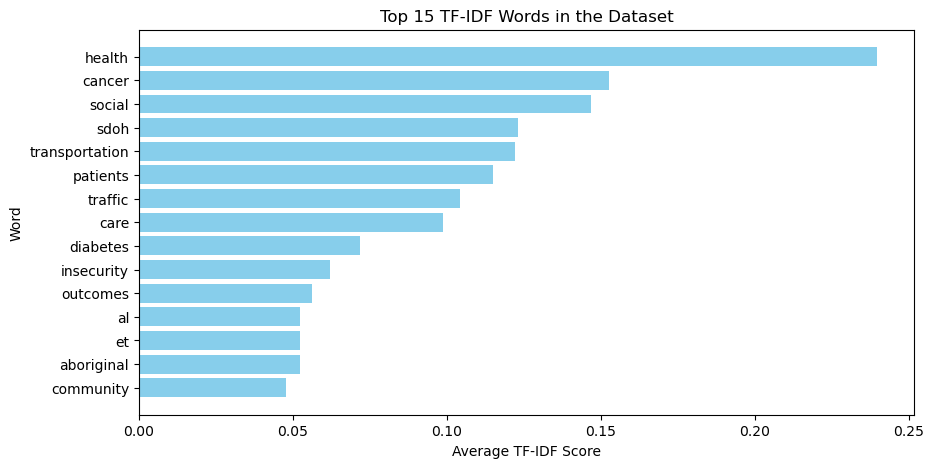

In [133]:
import matplotlib.pyplot as plt

# Get top words and scores
top_words = avg_tfidf_scores.head(15)
plt.figure(figsize=(10, 5))
plt.barh(top_words.index[::-1], top_words.values[::-1], color='skyblue')  # Reverse for better readability
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.title("Top 15 TF-IDF Words in the Dataset")
plt.show()


### Sentiment Analysis

In this section, we will analyze whether accessibility to public transportation is discussed as a positive, negative, or neutral factor to public health.

In [88]:
# IMPORT RELEVANT PACKAGES
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [89]:
# EXAMPLE OF SENTIMENT ANALYSIS

analyzer = SentimentIntensityAnalyzer()
text = "Accessible public transportation greatly improves patient access to healthcare services."
score = analyzer.polarity_scores(text)
score


{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.4754}

This above example sentence is mostly neutral but has some slightly positive sentiment, leaving it with a compound sentiment score of 0.4754. This is likely because of the "greatly improves" in the sentence.

In [90]:
analyzer.polarity_scores('As a result of transportation insecurity,\
   patients with cancer may forego, miss, delay, alter, and/or\
   prematurely terminate necessary care.')

{'neg': 0.392, 'neu': 0.495, 'pos': 0.113, 'compound': -0.7845}

In [91]:
texts = ["Transportation barriers limit healthcare access.", "Public transit improves patient mobility."]
labels = [0, 1]  # 0 = Negative, 1 = Positive

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

model = MultinomialNB()
model.fit(X, labels)

print(model.predict(vectorizer.transform(["Lack of transport worsens health outcomes."])))  # Output: [0]


[0]


In [92]:
def preprocess_sentence(word):
    word = re.sub(r"\d+", "", word) # remove numbers
    word = word.lower()
    if word not in stop_words:
        return word
    else:
        return ''

In [93]:
article_text2_sentences = ' '.join([' '.join([preprocess_sentence(word) for word in lst if type(preprocess(word)) != list]) for lst in no_blanks2])
article_text2_sentences = ' '.join([word.strip() for word in article_text2_sentences.split()])
article_text2_sentences

'abstract well recognized transportation barrier healthcare access rural-dwelling residents, particularly older adults. healthcare restructuring initiatives seldom take consideration complexity transportation, acts barrier appropriate timely access healthcare services older adults rural com\xad munities. article presents findings qualitative research study explored complex nature transportation challenges rural-dwelling older adults experience western canada trying access primary community care services. data derived larger study service user views healthcare restructuring initiative intended facilitate aging-in-place. conducted focus groups interviews diverse sample older adults living one urban centre nine rural small rural towns british columbia (bc)’s interior. used content analysis determine codes derive themes. study findings showed transportation top priority improving primary community care. older adult participants identified range transportation challenges trying get healthca

In [94]:
score1 = analyzer.polarity_scores(article_text2_sentences)
score1


{'neg': 0.032, 'neu': 0.83, 'pos': 0.138, 'compound': 0.9999}

In [95]:
article_text_sentences = ' '.join([' '.join([preprocess_sentence(word) for word in lst if type(preprocess(word)) != list]) for lst in no_blanks])
article_text_sentences = ' '.join([word.strip() for word in article_text_sentences.split()]).split('.')
article_text_sentences

['abstract health-care–related transportation insecurity common united states',
 ' patients cancer especially vulnerable cancer care episodic nature, occurs prolonged period, marked frequent clinical encounters, requires intense treatments, results substantial financial hardship',
 ' result transportation insecurity, patients cancer may forego, miss, delay, alter, and/or prematurely terminate necessary care',
 ' limited data suggest alterations care potential increase rates cancer recurrence mortality exacerbate disparities cancer incidence, severity, outcomes',
 ' transportation insecurity also negatively impacts informal caregiver, provider, health system, societal levels',
 ' recognizing transportation critical determinant outcomes patients cancer, ongoing efforts develop evidence-based protocols identify at-risk patients address transportation insecurity federal policy, health system, not-for-profit, industry levels',
 ' , national cancer policy forum national academies science, en

In [96]:
analyzer.polarity_scores(article_text_sentences)

{'neg': 0.243, 'neu': 0.637, 'pos': 0.12, 'compound': -1.0}